# Wrangle

Import modules

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os
from env import host, user, password
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

import warnings
warnings.filterwarnings("ignore")

alpha = 0.5

## Acquire

In [2]:
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
    
def new_zillow_data():
    '''
    This function reads the Bed/Bath count, Finished Sq Ft, Taxable Value, Year Built, and Amount Taxed
    from the 2017 Properties Zillow data from the Codeup SQL server into a df.
    '''
    sql_query = """
                SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
                taxvaluedollarcnt, yearbuilt, taxamount, fips
                FROM properties_2017
                JOIN predictions_2017 as p USING(parcelid)
                WHERE transactiondate < '2018-01-01' AND propertylandusetypeid LIKE '261'
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df

def get_zillow_data():
    '''
    This function reads in zillow data from the Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('zillow.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('zillow.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_zillow_data()
        
        # Cache data
        df.to_csv('zillow.csv')
        
    return df



## Prepare

In [3]:
### Remove outliers
def remove_outliers(df, k, col_list):
    ''' 
    Takes in a df, k, and list of columns returns
    a df with removed outliers
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

def prepare(df):
    '''
    Takes a zillow df as an argument and returns a df with handled nulls, removed nulls, changed column types,
    drop duplicates, and remove outliers. Drops taxamount to avoid data leak.
    '''
    # drop taxamount to prevent data leakage
    df.drop(columns = 'taxamount', inplace = True)
    # col_list for outliers
    col_list = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
            'taxvaluedollarcnt','yearbuilt']
    # run df through remove_outliers function for all columns
    df = remove_outliers(df, 1.5, col_list)
    
    # drop duplicates
    df.drop_duplicates()

    # for loop to change dtypes of appropriate columns to int
    for col in df.columns[df.columns != 'transactiondate']:
        df[col] = df[col].astype(int)

    return df

## Split

In [4]:
def split_data(df):
    '''
    Takes in a dataframe and returns train, validate, and test subset dataframes. 
    '''
    train, test = train_test_split(df, test_size = .2, random_state = 222)
    train, validate = train_test_split(train, test_size = .3, random_state = 222)
    return train, validate, test

## Scale

To scale bed and bath

In [5]:
def scale_zillow(train, validate, test):
    '''
    Takes train, validate, test datasets as an argument and returns the dataframes with 
    taxvaluedollarcnt, and calculatedfinishedsquarefeet scaled columns.
    '''
    ## MinMaxScaler
    scaler = sklearn.preprocessing.MinMaxScaler()

    # Fit scaler to data
    scaler.fit(train[['bedroomcnt','bathroomcnt','taxvaluedollarcnt', 'calculatedfinishedsquarefeet']])

    # Execute scaling
    train[['bedroomcnt_scaled','bathroomcnt_scaled','calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(train[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
    validate[['bedroomcnt_scaled','bathroomcnt_scaled','calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(validate[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
    test[['bedroomcnt_scaled','bathroomcnt_scaled','calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(test[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
    return train, validate, test

Only scale target and square ft

In [6]:
# def scale_zillow(train, validate, test):
#     '''
#     Takes train, validate, test datasets as an argument and returns the dataframes with 
#     taxvaluedollarcnt, and calculatedfinishedsquarefeet scaled columns.
#     '''
#     ## MinMaxScaler
#     scaler = sklearn.preprocessing.MinMaxScaler()

#     # Fit scaler to data
#     scaler.fit(train[['taxvaluedollarcnt', 'calculatedfinishedsquarefeet']])

#     # Execute scaling
#     train[['calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
#     validate[['calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(validate[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
#     test[['calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(test[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
#     return train, validate, test

## Wrangle
- All of the functions above combined

In [7]:
def wrangle_zillow():
    '''
    Combines all previously defined functions in the module to return
    train, validate, and test datasets.
    '''
    # Acquire
    df = get_zillow_data()
    # Prepare ###
    df = prepare(df)
    ### Split ### 
    train, validate, test = split_data(df)
    ### Scale ###
    train, validate, test = scale_zillow(train, validate, test)
    return train, validate, test

Test Wrangle functions

In [8]:
train, validate, test = wrangle_zillow()

## All functions defined to a module, wrangle.py

In [9]:
import wrangle

In [10]:
df = wrangle.get_zillow_data()
df = prepare(df)

In [11]:
train, validate, test = wrangle.wrangle_zillow()

In [12]:
train.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,bedroomcnt_scaled,bathroomcnt_scaled,calculatedfinishedsquarefeet_scaled,taxvaluedollarcnt_scaled
20886,4,2,1386,376186,1969,6037,0.666667,0.333333,0.000344,110.047995
27305,2,1,756,33710,1927,6037,0.000000,0.000000,-0.000217,9.820896
33996,3,2,1590,240752,1952,6037,0.333333,0.333333,0.000526,70.412643
20264,3,3,1904,660068,1943,6037,0.333333,0.666667,0.000805,193.127305
46755,3,1,972,425000,1952,6037,0.333333,0.000000,-0.000025,124.333626


In [13]:
train.shape

(25334, 10)

# Explore

## Ask Questions

In [14]:
import explore

In [15]:
# categories = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','fips','yearbuilt']
# continuous = ['taxvaluedollarcnt']
# explore.plot_categorical_and_continuous_vars(train.sample(3000),continuous,categories)

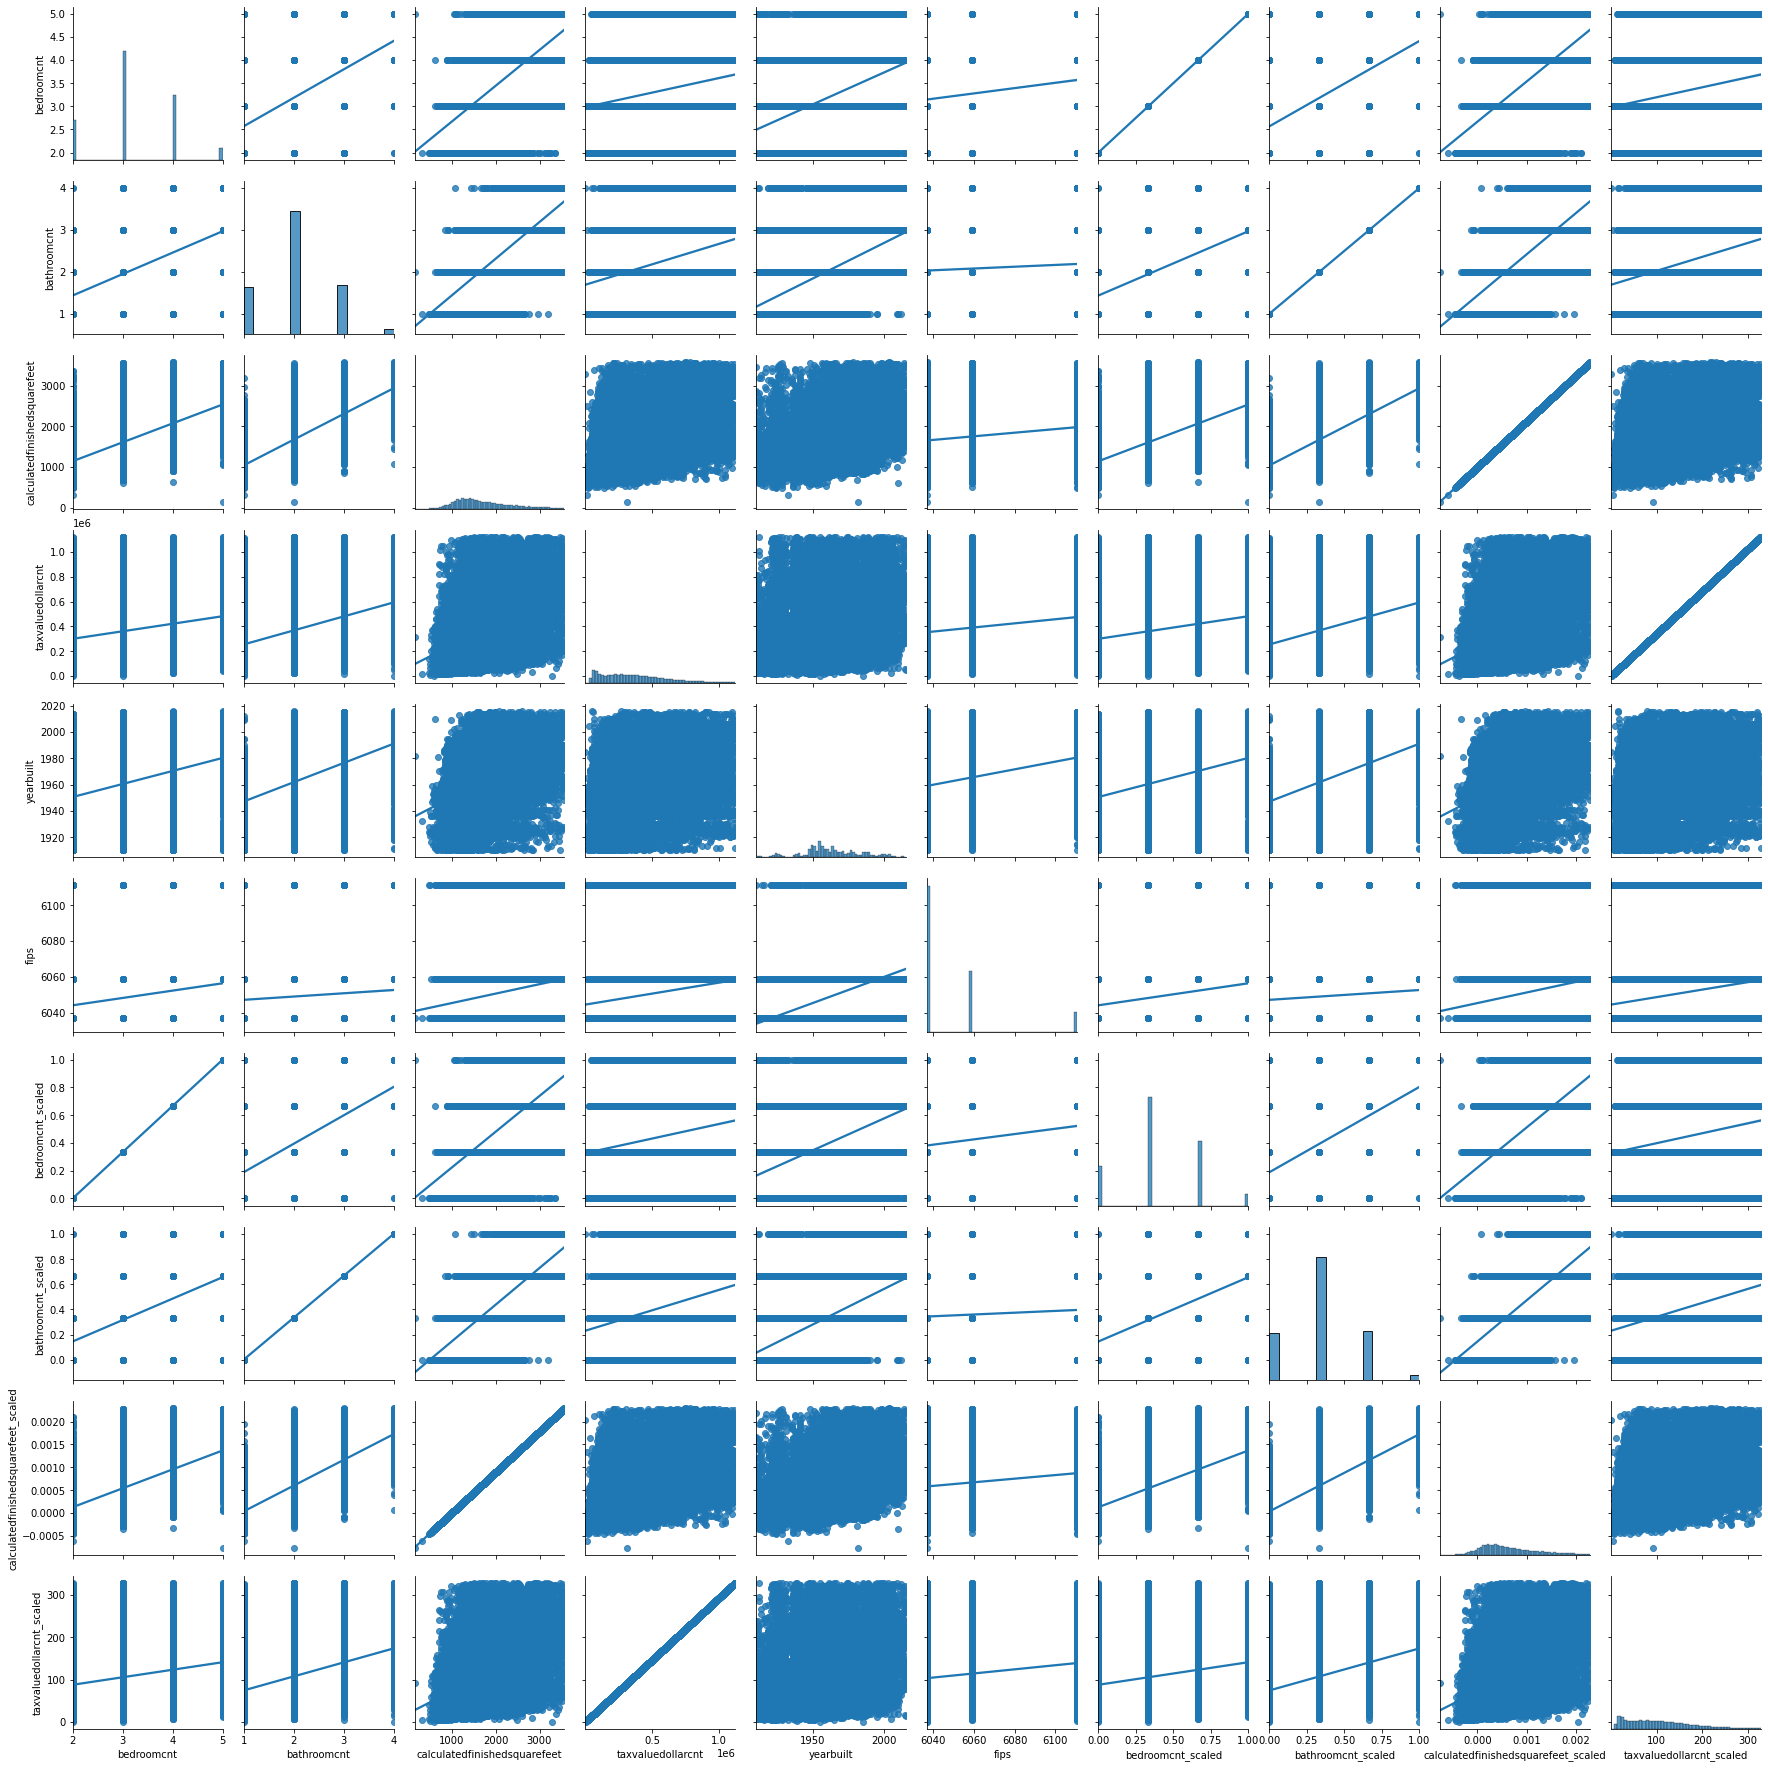

In [16]:
explore.plot_variable_pairs(train)

In [17]:
df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips
count,45241.000000,45241.000000,45241.000000,4.524100e+04,45241.000000,45241.000000
mean,3.214938,2.054729,1707.380717,3.739136e+05,1962.639818,6049.175991
std,0.788707,0.719510,613.315025,2.447182e+05,21.271268,21.176682
min,2.000000,1.000000,152.000000,1.000000e+03,1910.000000,6037.000000
25%,3.000000,2.000000,1243.000000,1.750680e+05,1950.000000,6037.000000
50%,3.000000,2.000000,1577.000000,3.377460e+05,1960.000000,6037.000000
75%,4.000000,2.000000,2072.000000,5.230440e+05,1977.000000,6059.000000
max,5.000000,4.000000,3569.000000,1.124001e+06,2016.000000,6111.000000


In [18]:
fips_count = pd.DataFrame(train.fips.value_counts())
fips_count.reset_index(inplace=True)
fips_count.rename(columns={'fips':'count','index':'fips'}, inplace=True)

<AxesSubplot:xlabel='fips', ylabel='count'>

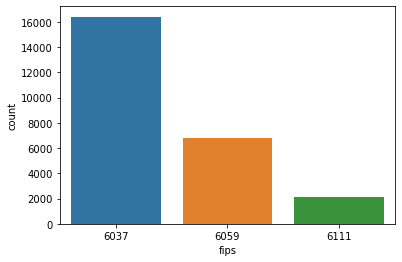

In [19]:
sns.barplot(y = 'count', x = 'fips', data=fips_count)

### 1. Do houses with higher square footage have a higher calculated tax value?
- $H_0$: There is no association between square footage and taxvalue
- $H_a$: There is an association between square footage and taxvalue

In [20]:
observe = pd.crosstab(train.taxvaluedollarcnt, train.calculatedfinishedsquarefeet)
chi2, p, degf, expected = stats.chi2_contingency(observe)
print('Observed\n')
print(observe.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis/")

Observed

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
---
Expected

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
---

chi^2 = 58302751.8501
p     = 0.0000
We reject the null hypothesis.


In [21]:
pd.qcut(train.calculatedfinishedsquarefeet, 10)

20886     (1308.0, 1440.0]
27305    (151.999, 1034.0]
33996     (1574.0, 1741.0]
20264     (1741.0, 1946.0]
46755    (151.999, 1034.0]
               ...        
9843      (1946.0, 2222.4]
7326      (1183.6, 1308.0]
13237     (1034.0, 1183.6]
11344     (2611.0, 3569.0]
36571     (1440.0, 1574.0]
Name: calculatedfinishedsquarefeet, Length: 25334, dtype: category
Categories (10, interval[float64]): [(151.999, 1034.0] < (1034.0, 1183.6] < (1183.6, 1308.0] < (1308.0, 1440.0] ... (1741.0, 1946.0] < (1946.0, 2222.4] < (2222.4, 2611.0] < (2611.0, 3569.0]]

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='taxvaluedollarcnt_scaled'>

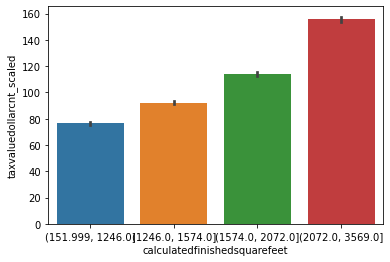

In [22]:
sns.barplot(x = pd.qcut(train.calculatedfinishedsquarefeet, 4),y='taxvaluedollarcnt_scaled',data=train)

### 2. Do houses with more bathrooms have a higher calculated tax value?

- $H_0$: There is no association between bathroom count and taxvalue
- $H_a$: There is an association between bathroom count and taxvalue

In [23]:
train.groupby('bathroomcnt').taxvaluedollarcnt.mean()

bathroomcnt
1    267279.521305
2    359056.191236
3    489043.217212
4    610241.624788
Name: taxvaluedollarcnt, dtype: float64

In [24]:
observe = pd.crosstab(train.taxvaluedollarcnt, train.bathroomcnt)
chi2, p, degf, expected = stats.chi2_contingency(observe)
print('Observed\n')
print(observe.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis/")

Observed

[[0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]]
---
Expected

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
---

chi^2 = 64567.4027
p     = 0.0000
We reject the null hypothesis.


<AxesSubplot:xlabel='bathroomcnt', ylabel='taxvaluedollarcnt'>

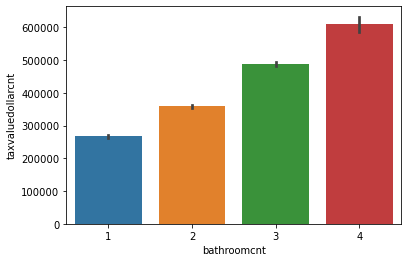

In [25]:
sns.barplot(x = 'bathroomcnt',y='taxvaluedollarcnt',data=train)

### 3. Do houses with more bedrooms have a higher calculated tax value?
- $H_0$: There is no association between bedroom count and taxvalue
- $H_a$: There is an association between bedroom count and taxvalue

In [26]:
train.groupby('bedroomcnt').taxvaluedollarcnt.mean()

bedroomcnt
2    310605.026814
3    354087.635824
4    427640.740512
5    483622.183396
Name: taxvaluedollarcnt, dtype: float64

In [27]:
observe = pd.crosstab(train.taxvaluedollarcnt, train.bedroomcnt)
chi2, p, degf, expected = stats.chi2_contingency(observe)
print('Observed\n')
print(observe.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis/")

Observed

[[0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]]
---
Expected

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
---

chi^2 = 62094.5222
p     = 0.0001
We reject the null hypothesis.


<AxesSubplot:xlabel='bedroomcnt', ylabel='taxvaluedollarcnt'>

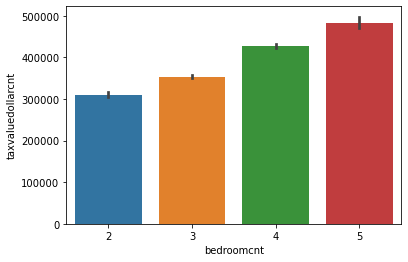

In [28]:
sns.barplot(x = 'bedroomcnt',y='taxvaluedollarcnt',data=train)

### 4. Do houses with less bedrooms and higher square footage have a lower tax value than houses with more bedrooms and a less square footage?

In [29]:
train[(train.bedroomcnt < 3) & (train.calculatedfinishedsquarefeet > 2000)].taxvaluedollarcnt.mean()

527221.0545454546

In [30]:
train[(train.bedroomcnt >= 3) & (train.calculatedfinishedsquarefeet < 2000)].taxvaluedollarcnt.mean()

322301.0009283062

In [31]:
temp = train[(train.bedroomcnt <= 3) & (train.calculatedfinishedsquarefeet > 2000)]
temp2 = train[(train.bedroomcnt > 3) & (train.calculatedfinishedsquarefeet < 2000)]

Text(0.5, 1.0, 'More than 3 bedrooms and Less than 2k SqFt')

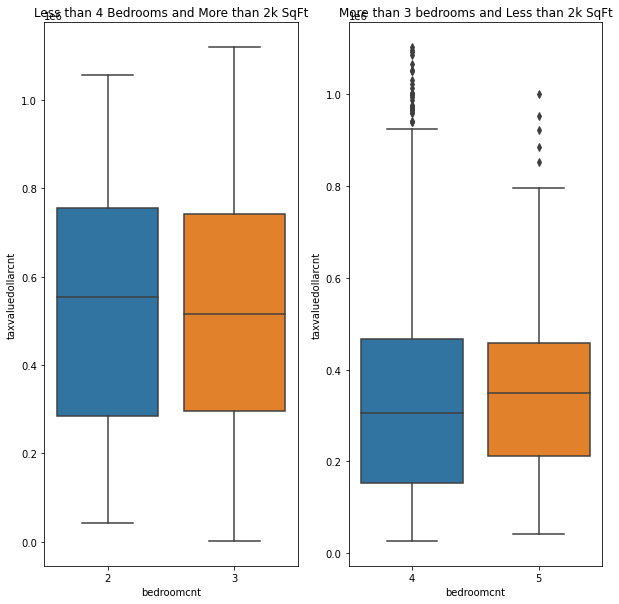

In [32]:
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    sns.boxplot(x='bedroomcnt',y='taxvaluedollarcnt',data=temp)
    plt.title('Less than 4 Bedrooms and More than 2k SqFt')
    plt.subplot(1,2,2)
    sns.boxplot(x='bedroomcnt',y='taxvaluedollarcnt',data=temp2)
    plt.title('More than 3 bedrooms and Less than 2k SqFt')

Houses with more sq ft and less rooms are generally worth more than houses with more bedrooms and less sq ft. This implies a larger impact on value from sq ft than bedrooms.

### 5. Do individual fips have higher average tax value?

- $H_0$: There is no association between location and taxvalue
- $H_a$: There is an association between location and taxvalue

In [33]:
observe = pd.crosstab(train.taxvaluedollarcnt, train.fips)
chi2, p, degf, expected = stats.chi2_contingency(observe)
print('Observed\n')
print(observe.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis/")

Observed

[[1 0 0]
 [1 0 0]
 [0 0 1]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
---
Expected

[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
---

chi^2 = 43773.9909
p     = 0.0000
We reject the null hypothesis.


### FIPS - Location

### 6037 - Los Angeles, CA

### 6059 - Orange, CA

### 6111 - Ventura, CA

In [34]:
train.fips.value_counts()

6037    16413
6059     6763
6111     2158
Name: fips, dtype: int64

In [35]:
train.groupby('fips').taxvaluedollarcnt.mean()

fips
6037    339001.466642
6059    443363.336093
6111    427013.200185
Name: taxvaluedollarcnt, dtype: float64

<AxesSubplot:xlabel='fips', ylabel='taxvaluedollarcnt'>

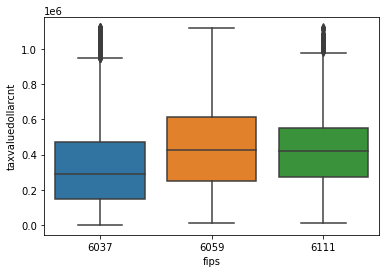

In [36]:
sns.boxplot(x=train.fips,y='taxvaluedollarcnt',data=train)

### 6. Do newer houses cost more than older houses?

- $H_0$: There is no association between year built and taxvalue
- $H_a$: There is an association between year built and taxvalue

In [37]:
    observe = pd.crosstab(train.taxvaluedollarcnt, train.yearbuilt)
    chi2, p, degf, expected = stats.chi2_contingency(observe)
    print('Observed\n')
    print(observe.values)
    print('---\nExpected\n')
    print(expected.astype(int))
    print('---\n')
    print(f'chi^2 = {chi2:.4f}')
    print(f'p     = {p:.4f}')
    if p < alpha:
        print("We reject the null hypothesis.")
    else:
        print("We fail to reject the null hypothesis/")

Observed

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
---
Expected

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
---

chi^2 = 2157745.5403
p     = 0.0000
We reject the null hypothesis.


Text(0.5, 0, 'year built')

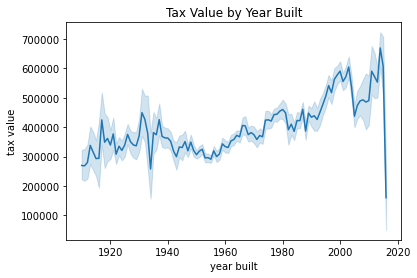

In [38]:
sns.lineplot(x = 'yearbuilt',y='taxvaluedollarcnt',data=train)
plt.title('Tax Value by Year Built')
plt.ylabel('tax value')
plt.xlabel('year built')

# Modeling

## Baseline

train.columns.to_list()

In [39]:
X_train = train.drop(columns=['taxvaluedollarcnt','taxvaluedollarcnt_scaled'])
X_train_scaled = train.drop(columns=['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt','yearbuilt','fips'])
y_train = train.taxvaluedollarcnt

X_validate = validate.drop(columns=['taxvaluedollarcnt','taxvaluedollarcnt_scaled'])
X_validate_scaled = train.drop(columns=['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt','yearbuilt','fips'])
y_validate = validate.taxvaluedollarcnt

X_test = test.drop(columns=['taxvaluedollarcnt','taxvaluedollarcnt_scaled'])
X_test_scaled = train.drop(columns=['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt','yearbuilt','fips'])
y_test = test.taxvaluedollarcnt

(array([4070., 4214., 4344., 4129., 3199., 2165., 1341.,  919.,  574.,
         379.]),
 array([1.0000000e+03, 1.1325540e+05, 2.2551080e+05, 3.3776620e+05,
        4.5002160e+05, 5.6227700e+05, 6.7453240e+05, 7.8678780e+05,
        8.9904320e+05, 1.0112986e+06, 1.1235540e+06]),
 <BarContainer object of 10 artists>)

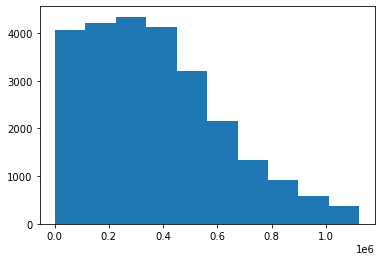

In [40]:
plt.hist(y_train)

In [41]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# predict mean
pred_mean = y_train.taxvaluedollarcnt.mean()
y_train['baseline_pred_mean'] = pred_mean
y_validate['baseline_pred_mean'] = pred_mean

# 2. predict median
pred_median = y_train.taxvaluedollarcnt.median()
y_train['baseline_pred_median'] = pred_median
y_validate['baseline_pred_median'] = pred_median

# 3. RMSE of mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.baseline_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.baseline_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.baseline_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.baseline_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.baseline_pred_median)
print('Explained Variance = ', round(evs,3))

RMSE using Mean
Train/In-Sample:  245330.65 
Validate/Out-of-Sample:  245581.31
RMSE using Median
Train/In-Sample:  247941.72 
Validate/Out-of-Sample:  248179.16
Explained Variance =  0.0


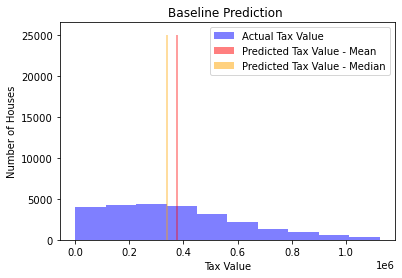

In [42]:
plt.vlines(ymin = 0, ymax = 25000, x = pred_mean, color='red', alpha=.5)
plt.vlines(ymin = 0, ymax = 25000, x = pred_median, color='orange', alpha = .5)

plt.hist(y_train.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_train.baseline_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Tax Value - Mean")
plt.hist(y_train.baseline_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Tax Value - Median")

plt.title('Baseline Prediction ')
plt.xlabel('Tax Value')
plt.ylabel('Number of Houses')
plt.legend()
plt.show()

In [43]:
X_train.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,fips,bedroomcnt_scaled,bathroomcnt_scaled,calculatedfinishedsquarefeet_scaled
20886,4,2,1386,1969,6037,0.666667,0.333333,0.000344
27305,2,1,756,1927,6037,0.000000,0.000000,-0.000217
33996,3,2,1590,1952,6037,0.333333,0.333333,0.000526
20264,3,3,1904,1943,6037,0.333333,0.666667,0.000805
46755,3,1,972,1952,6037,0.333333,0.000000,-0.000025


## OLS Model

In [44]:
# Create model
lm = LinearRegression(normalize=True,)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvalue_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lm)**(1/2)

# predict validate
y_validate['taxvalue_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lm)
print('Train Explained Variance = ', round(evs,3))
evs = explained_variance_score(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm)
print('Validate Explained Variance = ', round(evs,3))


RMSE for OLS using LinearRegression
Training/In-Sample:  217427.84472529616 
Validation/Out-of-Sample:  217916.21606795568
Train Explained Variance =  0.215
Validate Explained Variance =  0.213


## LassoLars Model

In [45]:
# create the model object
lars = LassoLars(alpha=50)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvalue_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lars)**(1/2)

# predict validate
y_validate['taxvalue_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lars)
print('Train Explained Variance = ', round(evs,3))
evs = explained_variance_score(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lars)
print('Validate Explained Variance = ', round(evs,3))

RMSE for Lasso + Lars
Training/In-Sample:  218885.95825362543 
Validation/Out-of-Sample:  219258.79939081572
Train Explained Variance =  0.204
Validate Explained Variance =  0.203


## Polynomial

In [46]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


In [47]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvalue_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lm2)**(1/2)

# predict validate
y_validate['taxvalue_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_lm2)
print('Train Explained Variance = ', round(evs,3))
evs = explained_variance_score(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm2)
print('Validate Explained Variance = ', round(evs,3))

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  213667.9635840494 
Validation/Out-of-Sample:  213912.327396917
Train Explained Variance =  0.241
Validate Explained Variance =  0.241


## GLM Model

In [48]:
# create the model object
glm = TweedieRegressor(power=2, alpha=0.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvalue_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_glm)**(1/2)

# predict validate
y_validate['taxvalue_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.taxvalue_pred_glm)
print('Train Explained Variance = ', round(evs,3))
evs = explained_variance_score(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_glm)
print('Validate Explained Variance = ', round(evs,3))

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  245330.6543933703 
Validation/Out-of-Sample:  245581.3121737097
Train Explained Variance =  0.0
Validate Explained Variance =  0.0


## Evaluate on Validate

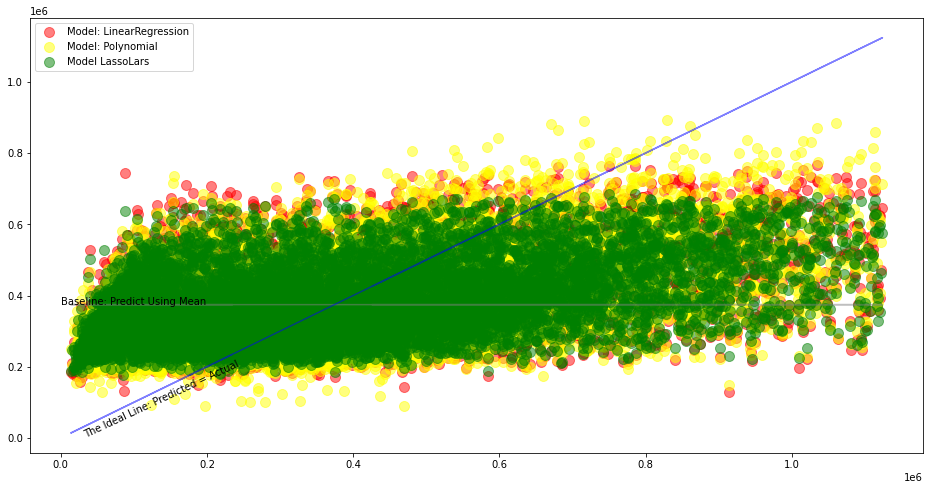

In [50]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.baseline_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, (pred_mean + 1000)))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (30000, 0), rotation=25)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm2, 
            alpha=.5, color="yellow", s=100, label="Model: Polynomial")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lars, 
            alpha=.5, color="green", s=100, label="Model LassoLars")
plt.legend()
plt.show()
# plt.xlabel("Actual Final Grade")
# plt.ylabel("Predicted Final Grade")
# plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
    

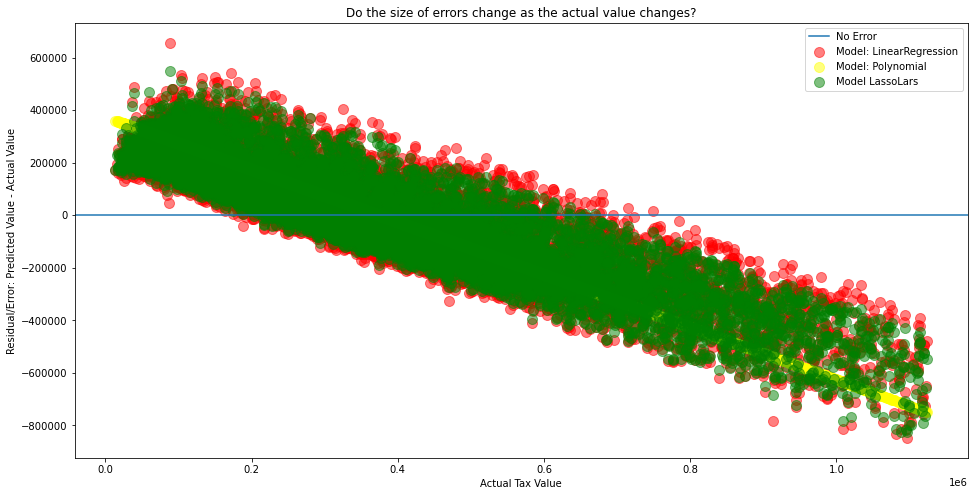

In [51]:
    plt.figure(figsize=(16,8))
    plt.axhline(label="No Error")
    plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lm-y_validate.taxvaluedollarcnt, 
                alpha=.5, color="red", s=100, label="Model: LinearRegression")
    plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_glm-y_validate.taxvaluedollarcnt, 
                alpha=.5, color="yellow", s=100, label="Model: Polynomial")
    plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvalue_pred_lars-y_validate.taxvaluedollarcnt, 
                alpha=.5, color="green", s=100, label="Model LassoLars")
    plt.legend()
    plt.xlabel("Actual Tax Value")
    plt.ylabel("Residual/Error: Predicted Value - Actual Value")
    plt.title("Do the size of errors change as the actual value changes?")
    plt.show()

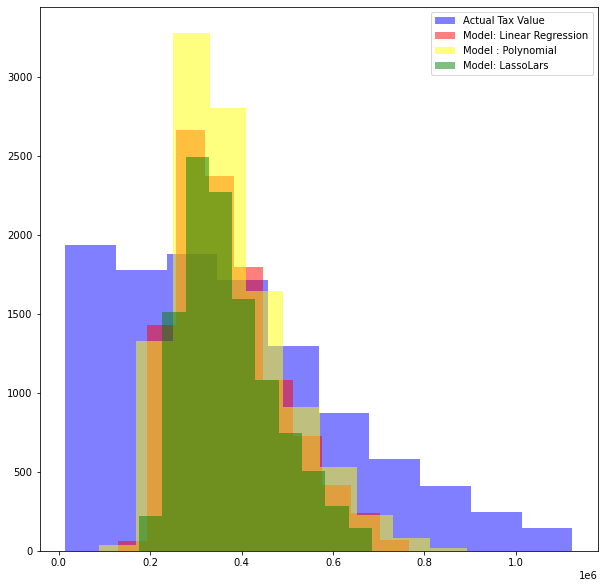

In [52]:
plt.figure(figsize=(10,10))
plt.hist(y_validate.taxvaluedollarcnt, color = 'blue',alpha = 0.5, label = 'Actual Tax Value')
plt.hist(y_validate.taxvalue_pred_lm, color = 'red',alpha = 0.5, label = 'Model: Linear Regression')
plt.hist(y_validate.taxvalue_pred_lm2, color = 'yellow',alpha = 0.5, label = 'Model : Polynomial')
plt.hist(y_validate.taxvalue_pred_lars, color = 'green',alpha=0.5,label='Model: LassoLars')

plt.legend();

## Evaluate on Test

In [53]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['taxvalue_pred_lars'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.taxvalue_pred_lars)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

evs = explained_variance_score(y_test.taxvaluedollarcnt, y_test.taxvalue_pred_lars)
print('Test Explained Variance = ', round(evs,3))

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  213987.8819614112
Test Explained Variance =  0.218


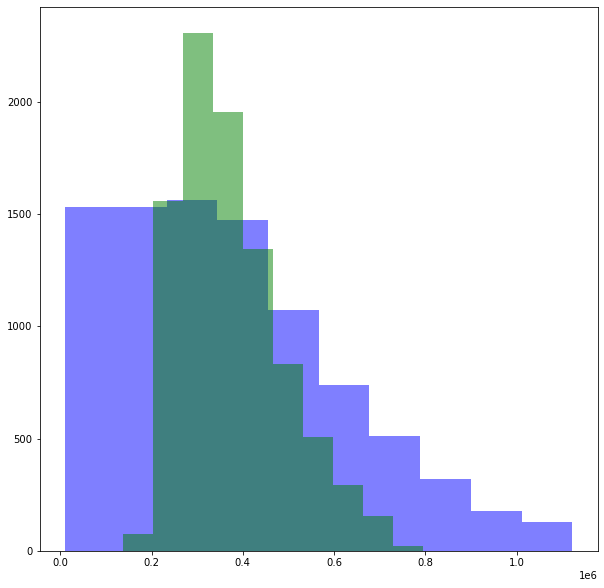

In [54]:
plt.figure(figsize=(10,10))
plt.hist(y_test.taxvaluedollarcnt, color = 'blue',alpha = 0.5, label = 'Actual Tax Value')
plt.hist(y_test.taxvalue_pred_lars, color = 'green',alpha=0.5,label='Model: LassoLars');